# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [28]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as sf
import pyspark.sql.types as st
from pyspark.sql import Window

import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify Project Small") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
data_filepath = 'data/mini_sparkify_event_data.json'

In [4]:
df = spark.read.json(data_filepath)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [14]:
df.select([sf.count(sf.when(sf.isnan(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [18]:
df.select([sf.count(sf.when(sf.isnan(c) | sf.col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas().T

,0
artist,58392
auth,0
firstName,8346
gender,8346
itemInSession,0
lastName,8346
length,58392
level,0
location,8346
method,0


In [6]:
df.head(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [7]:
df.count()

286500

In [8]:
df.describe().toPandas()

,summary,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,count,228108,286500,278154,278154,286500,278154,228108,286500,278154,286500,286500,278154,286500,228108,286500,286500,278154,286500
1,mean,551.0852017937219,None,None,None,114.41421291448516,None,249.1171819778458,None,None,None,None,1.5353588340844272E12,1041.526554973822,Infinity,210.05459685863875,1.5409568898104834E12,None,59682.02278593872
2,stddev,1217.7693079161374,None,None,None,129.76726201140994,None,99.23517921058361,None,None,None,None,3.291321616327586E9,726.7762634630741,NaN,31.50507848842214,1.5075439608226302E9,None,109091.9499991047
3,min,!!!,Cancelled,Adelaida,F,0,Adams,0.78322,free,"Albany, OR",GET,About,1521380675000,1,ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku,200,1538352117000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",
4,max,ÃÂlafur Arnalds,Logged Out,Zyonna,M,1321,Wright,3024.66567,paid,"Winston-Salem, NC",PUT,Upgrade,1543247354000,2474,ÃÂau hafa sloppiÃÂ° undan ÃÂ¾unga myrkursins,404,1543799476000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,99


### Describe numeric columns

In [9]:
numeric_cols = ['itemInSession','length', 'registration', 'sessionId', 'status', 'ts']

In [10]:
df.describe(numeric_cols).toPandas()

,summary,itemInSession,length,registration,sessionId,status,ts
0,count,286500,228108,278154,286500,286500,286500
1,mean,114.41421291448516,249.1171819778458,1.5353588340844272E12,1041.526554973822,210.05459685863875,1.5409568898104834E12
2,stddev,129.76726201140994,99.23517921058361,3.291321616327586E9,726.7762634630741,31.50507848842214,1.5075439608226302E9
3,min,0,0.78322,1521380675000,1,200,1538352117000
4,max,1321,3024.66567,1543247354000,2474,404,1543799476000


### Describe categorical columns

In [11]:
cat_cols = [col for col in df.columns if col not in numeric_cols]

In [12]:
for column in cat_cols:
    print('Column:' + column)
    print(df.groupBy(column).count().sort('count', ascending=False).toPandas())
    print('===================================================================')

Column:artist
                                                  artist  count
0                                                   None  58392
1                                          Kings Of Leon   1841
2                                               Coldplay   1813
3                                 Florence + The Machine   1236
4                                          Dwight Yoakam   1135
5                                               BjÃÂ¶rk   1133
6                                         The Black Keys   1125
7                                                   Muse   1090
8                                          Justin Bieber   1044
9                                           Jack Johnson   1007
10                                                Eminem    953
11                                             Radiohead    884
12                                       Alliance Ethnik    876
13                                                 Train    854
14                        

  method   count
0    PUT  261064
1    GET   25436
Column:page
                         page   count
0                    NextSong  228108
1                        Home   14457
2                   Thumbs Up   12551
3             Add to Playlist    6526
4                  Add Friend    4277
5                 Roll Advert    3933
6                       Login    3241
7                      Logout    3226
8                 Thumbs Down    2546
9                   Downgrade    2055
10                       Help    1726
11                   Settings    1514
12                      About     924
13                    Upgrade     499
14              Save Settings     310
15                      Error     258
16             Submit Upgrade     159
17           Submit Downgrade      63
18                     Cancel      52
19  Cancellation Confirmation      52
20                   Register      18
21        Submit Registration       5
Column:song
                                                   

     userId  count
0        39   9632
1             8346
2        92   7230
3       140   6880
4    300011   5732
5       124   4825
6    300021   4659
7    300017   4428
8        85   4370
9        42   4257
10   200023   3769
11        6   3761
12       29   3603
13       54   3437
14      100   3214
15        9   3191
16      126   3102
17   300015   3051
18       91   3014
19       98   2891
20       74   2887
21      118   2868
22      136   2567
23       65   2544
24      138   2469
25       88   2465
26       51   2464
27        4   2442
28       97   2404
29       81   2335
..      ...    ...
196  300007    143
197     144    125
198     154    118
199      72    117
200      57    112
201      32    108
202      63    107
203  300024    102
204      84     97
205  100019     89
206  200012     84
207     116     79
208  100003     78
209  200007     76
210  100017     75
211      34     73
212      64     68
213     122     62
214     134     52
215      68     48
216      90 

In [52]:
get_timestamp = sf.udf(lambda x : datetime.datetime.fromtimestamp(x/ 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

In [53]:
df = df.withColumn("datetime", get_timestamp(df.ts))

In [54]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', datetime='2018-10-01 00:01:57')

### EDA Overall Questions

#### - Who are the top-10 Artists overall?

In [20]:
top10_artists = df.filter(df.artist != 'None').groupBy('artist').count().sort('count', ascending=False).toPandas().iloc[:10,:]
top10_artists

,artist,count
0,Kings Of Leon,1841
1,Coldplay,1813
2,Florence + The Machine,1236
3,Dwight Yoakam,1135
4,BjÃÂ¶rk,1133
5,The Black Keys,1125
6,Muse,1090
7,Justin Bieber,1044
8,Jack Johnson,1007
9,Eminem,953


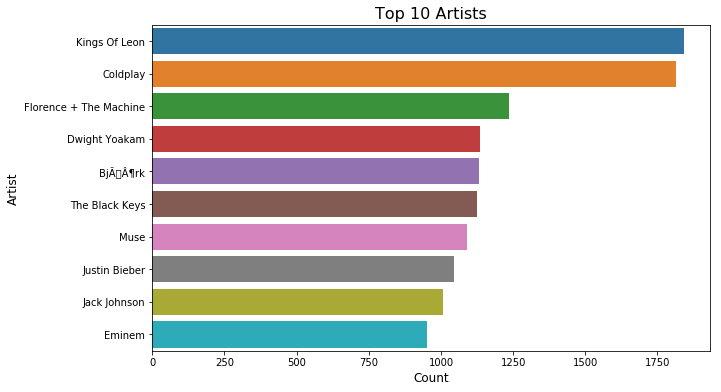

In [31]:
f, axis = plt.subplots(figsize=(10, 6))
sns.barplot(x="count", y="artist", data=top10_artists)
plt.title('Top 10 Artists',size=16);
plt.xlabel('Count', size=12)
plt.ylabel('Artist', size=12);

In [32]:
f.savefig("./assets/top-10-artists.png", bbox_inches='tight', dpi=600)

#### - Which are the top-10 songs overall?

In [44]:
top10_songs = df.filter(df.song != 'None').groupBy('song').count().sort('count', ascending=False) \
                .toPandas().iloc[:10,:] \
                .assign(song = lambda x: x.song if len(x.song) <= 25 else x.song.str[:25] + '...')
top10_songs

,song,count
0,You're The One,1153
1,Undo,1026
2,Revelry,854
3,Sehr kosmisch,728
4,Horn Concerto No. 4 in E flat K495: II. Romanc...,641
5,Dog Days Are Over (Radio Edit),574
6,Secrets,466
7,Use Somebody,459
8,Canada,435
9,Invalid,424


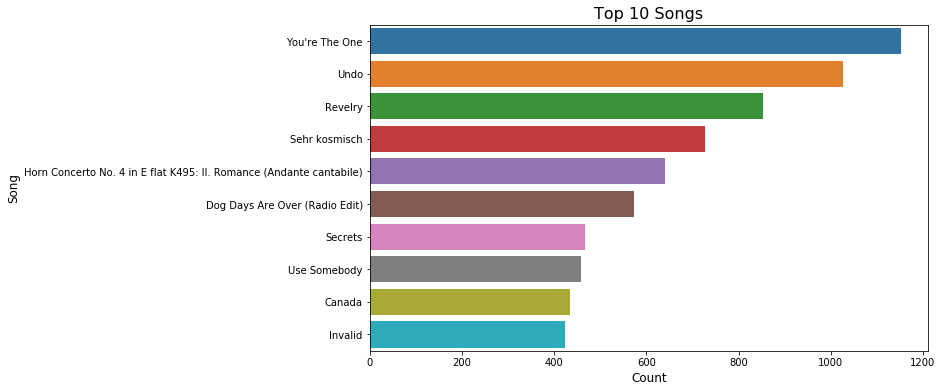

In [45]:
f, axis = plt.subplots(figsize=(10, 6))
sns.barplot(x="count", y="song", data=top10_songs)
plt.title('Top 10 Songs',size=16)
plt.xlabel('Count', size=12)
plt.ylabel('Song', size=12);

In [46]:
f.savefig("./assets/top-10-songs.png", bbox_inches='tight', dpi=600)

#### - How is the distribution of listening time for paid versus free users?

In [48]:
non_null_listening_time = df.filter(df.length.isNotNull()).select(['level','length']).toPandas()
non_null_listening_time.head(10)

,level,length
0,paid,277.89016
1,free,236.09424
2,paid,282.82730
3,free,262.71302
4,paid,223.60771
5,free,208.29995
6,free,260.46649
7,paid,185.44281
8,paid,134.47791
9,free,229.87710


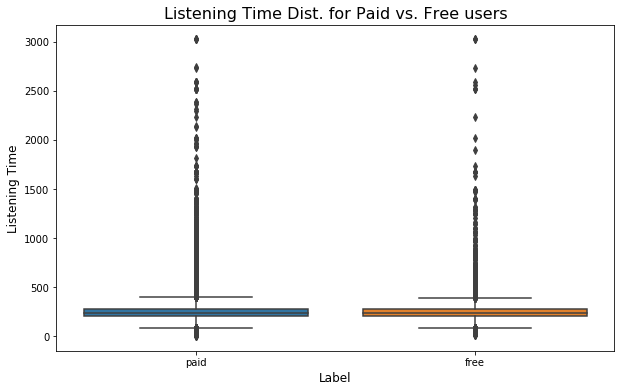

In [49]:
f, axis = plt.subplots(figsize=(10, 6))
sns.boxplot(x="level", y="length", data=non_null_listening_time);
plt.title('Listening Time Dist. for Paid vs. Free users',size=16)
plt.xlabel('Label', size=12)
plt.ylabel('Listening Time', size=12);

In [50]:
f.savefig("./assets/list-time-paid-free-users.png", bbox_inches='tight', dpi=600)

#### - How is the distribution of the average number of songs listened along the hours of the day for paid versus free versus all users?

In [55]:
get_datetime_hour = sf.udf(lambda x: None if x == None else int(x.split(' ')[1][:2]), st.IntegerType())
df = df.withColumn('hour', get_datetime_hour('datetime'))
get_datetime_date = sf.udf(lambda x: None if x == None else x.split(' ')[0])
df = df.withColumn('date', get_datetime_date('datetime'))
songs_per_hour_level = df.filter(df.song != 'None').groupBy(['level','date','hour']).count().groupBy(['level','hour']).agg(sf.avg('count').alias('mean_num_songs')).sort('mean_num_songs', ascending=False).toPandas()
songs_per_hour_level

,level,hour,mean_num_songs
0,paid,16,149.344262
1,paid,17,148.475410
2,paid,18,147.409836
3,paid,19,147.229508
4,paid,15,145.098361
5,paid,20,144.786885
6,paid,21,140.114754
7,paid,22,134.934426
8,paid,14,134.426230
9,paid,23,130.163934


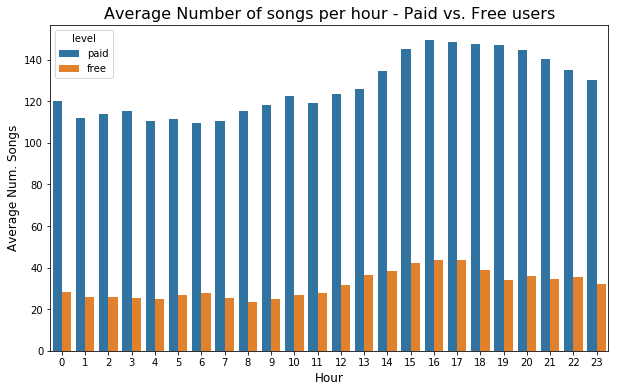

In [56]:
f, axis = plt.subplots(figsize=(10, 6))
sns.barplot(x="hour", y="mean_num_songs", hue='level', data=songs_per_hour_level);
plt.title('Average Number of songs per hour - Paid vs. Free users',size=16)
plt.xlabel('Hour', size=12)
plt.ylabel('Average Num. Songs', size=12);

In [57]:
f.savefig("./assets/avg-num-songs-per-hour.png", bbox_inches='tight', dpi=600)

#### - How is the distribution of users per region?

In [58]:
get_region = sf.udf(lambda x: None if x == None else x.split(',')[1])
df = df.withColumn('region', get_region('location'))
users_per_region = df.filter(df.region != 'None').groupBy('region').count().sort('count', ascending=False).toPandas()
users_per_region.head(10)

,region,count
0,CA,46771
1,NY-NJ-PA,23684
2,TX,23494
3,MA-NH,13873
4,FL,13190
5,NC,10688
6,NC-SC,7780
7,CO,7493
8,MI,7216
9,NJ,7001


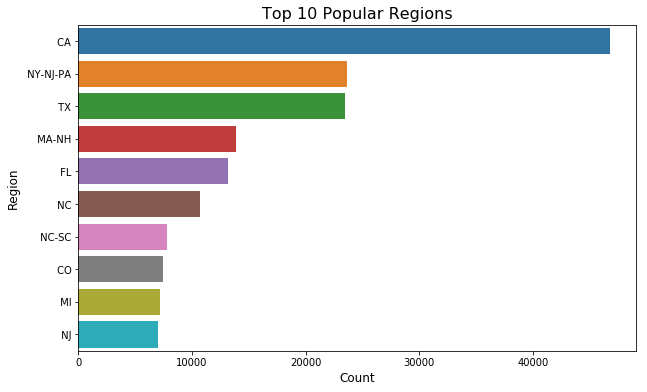

In [59]:
f, axis = plt.subplots(figsize=(10, 6))
sns.barplot(x="count", y="region", data=users_per_region.head(10));
plt.title('Top 10 Popular Regions',size=16)
plt.xlabel('Count', size=12)
plt.ylabel('Region', size=12);

In [60]:
f.savefig("./assets/activity-per-region.png", bbox_inches='tight', dpi=600)

## Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Create Churn column based on the Cancellation Confirmation event

#### Overview of the Cancellation Confirmation event on the dataset

In [26]:
df.filter(df.page == 'Cancellation Confirmation').take(5)

[Row(artist=None, auth='Cancelled', firstName='Adriel', gender='M', itemInSession=104, lastName='Mendoza', length=None, level='paid', location='Kansas City, MO-KS', method='GET', page='Cancellation Confirmation', registration=1535623466000, sessionId=514, song=None, status=200, ts=1538943990000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"', userId='18', datetime='2018-10-07 20:26:30', hour=20, date='2018-10-07', region=' MO-KS'),
 Row(artist=None, auth='Cancelled', firstName='Diego', gender='M', itemInSession=56, lastName='Mckee', length=None, level='paid', location='Phoenix-Mesa-Scottsdale, AZ', method='GET', page='Cancellation Confirmation', registration=1537167593000, sessionId=540, song=None, status=200, ts=1539033046000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='32', datetime='2

In [27]:
df.select(["userId", "datetime", "page", "level", "length"]).filter(df.userId == '125').collect()

[Row(userId='125', datetime='2018-10-12 04:05:44', page='NextSong', level='free', length=337.91955),
 Row(userId='125', datetime='2018-10-12 04:11:21', page='NextSong', level='free', length=230.03383),
 Row(userId='125', datetime='2018-10-12 04:15:11', page='NextSong', level='free', length=203.2322),
 Row(userId='125', datetime='2018-10-12 04:18:34', page='NextSong', level='free', length=210.83383),
 Row(userId='125', datetime='2018-10-12 04:22:04', page='NextSong', level='free', length=391.26159),
 Row(userId='125', datetime='2018-10-12 04:28:35', page='NextSong', level='free', length=213.60281),
 Row(userId='125', datetime='2018-10-12 04:32:08', page='NextSong', level='free', length=178.41587),
 Row(userId='125', datetime='2018-10-12 04:35:06', page='NextSong', level='free', length=323.81342),
 Row(userId='125', datetime='2018-10-12 04:35:17', page='Roll Advert', level='free', length=None),
 Row(userId='125', datetime='2018-10-12 04:35:18', page='Cancel', level='free', length=None),


In [28]:
flag_churn_1 = sf.udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, st.IntegerType())

In [29]:
df = df.withColumn("churned1", flag_churn_1("page"))

In [30]:
df.select(["userId", "datetime", "page", "level", "length", "churned1"]).filter(df.userId == '125').collect()

[Row(userId='125', datetime='2018-10-12 04:05:44', page='NextSong', level='free', length=337.91955, churned1=0),
 Row(userId='125', datetime='2018-10-12 04:11:21', page='NextSong', level='free', length=230.03383, churned1=0),
 Row(userId='125', datetime='2018-10-12 04:15:11', page='NextSong', level='free', length=203.2322, churned1=0),
 Row(userId='125', datetime='2018-10-12 04:18:34', page='NextSong', level='free', length=210.83383, churned1=0),
 Row(userId='125', datetime='2018-10-12 04:22:04', page='NextSong', level='free', length=391.26159, churned1=0),
 Row(userId='125', datetime='2018-10-12 04:28:35', page='NextSong', level='free', length=213.60281, churned1=0),
 Row(userId='125', datetime='2018-10-12 04:32:08', page='NextSong', level='free', length=178.41587, churned1=0),
 Row(userId='125', datetime='2018-10-12 04:35:06', page='NextSong', level='free', length=323.81342, churned1=0),
 Row(userId='125', datetime='2018-10-12 04:35:17', page='Roll Advert', level='free', length=None,

### Create Churn2 column considering the Submit Downgrade event

#### Overview of the Submit Downgrade event on the dataset

In [31]:
df.filter(df.page == 'Submit Downgrade').take(5)

[Row(artist=None, auth='Logged In', firstName='Kael', gender='M', itemInSession=47, lastName='Baker', length=None, level='paid', location='Kingsport-Bristol-Bristol, TN-VA', method='PUT', page='Submit Downgrade', registration=1533102330000, sessionId=249, song=None, status=307, ts=1538393619000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"', userId='131', datetime='2018-10-01 11:33:39', hour=11, date='2018-10-01', region=' TN-VA', churned1=0),
 Row(artist=None, auth='Logged In', firstName='Calvin', gender='M', itemInSession=17, lastName='Marshall', length=None, level='paid', location='Pittsburgh, PA', method='PUT', page='Submit Downgrade', registration=1537120757000, sessionId=313, song=None, status=307, ts=1538516445000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.78.2 (KHTML, like Gecko) Version/7.0.6 Safari/537.78.2"', userId='38', datetime='2018-10-02 21:40:45', hour

In [32]:
df.select(["userId", "datetime", "page", "level", "length"]).filter(df.userId == '30').collect()

[Row(userId='30', datetime='2018-10-01 00:01:57', page='NextSong', level='paid', length=277.89016),
 Row(userId='30', datetime='2018-10-01 00:06:34', page='NextSong', level='paid', length=282.8273),
 Row(userId='30', datetime='2018-10-01 00:11:16', page='NextSong', level='paid', length=223.60771),
 Row(userId='30', datetime='2018-10-01 00:14:59', page='NextSong', level='paid', length=185.44281),
 Row(userId='30', datetime='2018-10-01 00:15:05', page='Add to Playlist', level='paid', length=None),
 Row(userId='30', datetime='2018-10-01 00:18:04', page='NextSong', level='paid', length=134.47791),
 Row(userId='30', datetime='2018-10-01 00:20:18', page='NextSong', level='paid', length=223.58159),
 Row(userId='30', datetime='2018-10-01 00:24:01', page='NextSong', level='paid', length=246.69995),
 Row(userId='30', datetime='2018-10-01 00:28:07', page='NextSong', level='paid', length=222.22322),
 Row(userId='30', datetime='2018-10-01 00:31:49', page='NextSong', level='paid', length=223.92118),

In [33]:
home_acc_window = Window.partitionBy("userId").orderBy("ts").rangeBetween(Window.unboundedPreceding, 0)

In [34]:
df = df.withColumn('next_level', sf.lead('level').over(
    Window.partitionBy('userId').orderBy('ts')
    )
)

In [35]:
flag_churn_2 = sf.udf(lambda x, y: 1 if (x == "Submit Downgrade" and y == "free") else 0, st.IntegerType())

In [36]:
df = df.withColumn("churned2", flag_churn_2("page","next_level"))

In [37]:
df.select(["userId", "datetime", "page", "level", "length", "next_level", "churned2"]).filter(df.userId == '30').collect()

[Row(userId='30', datetime='2018-10-01 00:01:57', page='NextSong', level='paid', length=277.89016, next_level='paid', churned2=0),
 Row(userId='30', datetime='2018-10-01 00:06:34', page='NextSong', level='paid', length=282.8273, next_level='paid', churned2=0),
 Row(userId='30', datetime='2018-10-01 00:11:16', page='NextSong', level='paid', length=223.60771, next_level='paid', churned2=0),
 Row(userId='30', datetime='2018-10-01 00:14:59', page='NextSong', level='paid', length=185.44281, next_level='paid', churned2=0),
 Row(userId='30', datetime='2018-10-01 00:15:05', page='Add to Playlist', level='paid', length=None, next_level='paid', churned2=0),
 Row(userId='30', datetime='2018-10-01 00:18:04', page='NextSong', level='paid', length=134.47791, next_level='paid', churned2=0),
 Row(userId='30', datetime='2018-10-01 00:20:18', page='NextSong', level='paid', length=223.58159, next_level='paid', churned2=0),
 Row(userId='30', datetime='2018-10-01 00:24:01', page='NextSong', level='paid', l

### Create Churn3 column considering both Cancellation Confirmation and Submit Downgrade events

In [38]:
or_between_cols = sf.udf(lambda x, y: 1 if ((x == 1) | (y == 1)) else 0, st.IntegerType())

In [39]:
df = df.withColumn("churned3", or_between_cols("churned1","churned2"))

In [40]:
df.select(["datetime", "page", "level", "next_level", "churned1", "churned2", "churned3"]).filter(df.userId == '30').collect()

[Row(datetime='2018-10-01 00:01:57', page='NextSong', level='paid', next_level='paid', churned1=0, churned2=0, churned3=0),
 Row(datetime='2018-10-01 00:06:34', page='NextSong', level='paid', next_level='paid', churned1=0, churned2=0, churned3=0),
 Row(datetime='2018-10-01 00:11:16', page='NextSong', level='paid', next_level='paid', churned1=0, churned2=0, churned3=0),
 Row(datetime='2018-10-01 00:14:59', page='NextSong', level='paid', next_level='paid', churned1=0, churned2=0, churned3=0),
 Row(datetime='2018-10-01 00:15:05', page='Add to Playlist', level='paid', next_level='paid', churned1=0, churned2=0, churned3=0),
 Row(datetime='2018-10-01 00:18:04', page='NextSong', level='paid', next_level='paid', churned1=0, churned2=0, churned3=0),
 Row(datetime='2018-10-01 00:20:18', page='NextSong', level='paid', next_level='paid', churned1=0, churned2=0, churned3=0),
 Row(datetime='2018-10-01 00:24:01', page='NextSong', level='paid', next_level='paid', churned1=0, churned2=0, churned3=0),
 

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### Churn EDA Questions

#### - How is the distribution of churning/downgrading/cancelling users over the months of the year?

In [41]:
get_datetime_month = sf.udf(lambda x: None if x == None else int(x.split(' ')[0][5:7]), st.IntegerType())
df = df.withColumn('month', get_datetime_month('datetime'))
df.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', datetime='2018-10-08 12:58:54', hour=12, date='2018-10-08', region=' CT', churned1=0, next_level='free', churned2=0, churned3=0, month=10)

In [42]:
churning_per_month = df.groupBy('month').agg(
                        (sf.sum('churned1')/sf.countDistinct('userId')).alias('cancelled'),
                        (sf.sum('churned2')/sf.countDistinct('userId')).alias('downgraded'),
                        (sf.sum('churned3')/sf.countDistinct('userId')).alias('churned')) \
                        .toPandas() \
                    .melt(id_vars=['month'], 
                          value_vars=['cancelled','downgraded','churned'],
                          var_name='Churn Type',
                          value_name='prop')

churning_per_month

,month,Churn Type,prop
0,12,cancelled,0.000000
1,10,cancelled,0.140187
2,11,cancelled,0.117021
3,12,downgraded,0.000000
4,10,downgraded,0.172897
5,11,downgraded,0.132979
6,12,churned,0.000000
7,10,churned,0.313084
8,11,churned,0.250000


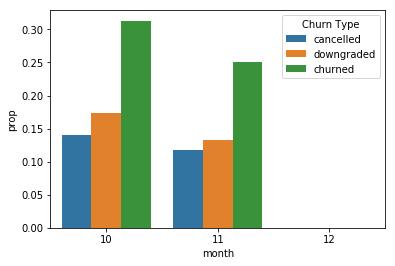

In [43]:
sns.barplot(x="month", y="prop", hue="Churn Type", data=churning_per_month);

#### - How is the distribution of churning/downgrading/cancelling users per region?

In [44]:
churning_per_region = df.groupBy('region').agg(
                        (sf.sum('churned1')/sf.countDistinct('userId')).alias('cancelled'),
                        (sf.sum('churned2')/sf.countDistinct('userId')).alias('downgraded'),
                        (sf.sum('churned3')/sf.countDistinct('userId')).alias('churned'),
                        (sf.countDistinct('userId').alias('users'))) \
                        .toPandas() \
                    .melt(id_vars=['region'], 
                          value_vars=['cancelled','downgraded','churned','users'],
                          var_name='Churn Type',
                          value_name='prop') \
                    .sort_values(['prop'], ascending=False)

churning_per_region.head(10)

,region,Churn Type,prop
203,CA,users,33.0
206,TX,users,16.0
204,NY-NJ-PA,users,15.0
199,FL,users,14.0
190,AZ,users,7.0
220,CT,users,7.0
231,NC-SC,users,6.0
194,MO-IL,users,6.0
184,IL-IN-WI,users,6.0
235,NC,users,6.0


In [45]:
largest_regions = churning_per_region[churning_per_region['Churn Type'] == 'users'].sort_values('prop', ascending=False)
largest_regions

,region,Churn Type,prop
203,CA,users,33.0
206,TX,users,16.0
204,NY-NJ-PA,users,15.0
199,FL,users,14.0
190,AZ,users,7.0
220,CT,users,7.0
231,NC-SC,users,6.0
194,MO-IL,users,6.0
184,IL-IN-WI,users,6.0
235,NC,users,6.0


In [46]:
filtered_regions = largest_regions[largest_regions['prop'] >=10]
filtered_regions

,region,Churn Type,prop
203,CA,users,33.0
206,TX,users,16.0
204,NY-NJ-PA,users,15.0
199,FL,users,14.0


In [47]:
top_churning_per_region = churning_per_region[(churning_per_region['region'].isin(filtered_regions['region'])) & (churning_per_region['Churn Type'] != 'users')]
top_churning_per_region

,region,Churn Type,prop
145,NY-NJ-PA,churned,0.666667
144,CA,churned,0.666667
140,FL,churned,0.642857
85,CA,downgraded,0.484848
147,TX,churned,0.437500
81,FL,downgraded,0.428571
86,NY-NJ-PA,downgraded,0.333333
27,NY-NJ-PA,cancelled,0.333333
88,TX,downgraded,0.250000
22,FL,cancelled,0.214286


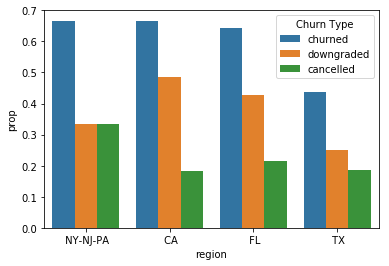

In [48]:
sns.barplot(x="region", y="prop", hue="Churn Type", data=top_churning_per_region);

#### - How is the distribution of listening time for:
    

* churning versus non-churning users?

In [49]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- region: string (nullable = true)
 |-- churned1: integer (nullable = true)
 |-- next_level: string (nullable = true)
 |-- churned2: integer (nullable = true)
 |-- churned3: integer (nullabl

In [50]:
df.take(5)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', datetime='2018-10-08 12:58:54', hour=12, date='2018-10-08', region=' CT', churned1=0, next_level='free', churned2=0, churned3=0, month=10),
 Row(artist='Francesca Battistelli', auth='Logged In', firstName='Darianna', gender='F', itemInSession=1, lastName='Carpenter', length=196.54485, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Beautiful_ Beautiful (Album)', status=200, ts=15390

In [51]:
user_churned = sf.udf(lambda x: 1 if sf.sum(x) > 0 else 0)

In [52]:
churning_users = df.groupby('userId').agg(sf.sum('churned3').alias('churned')).toPandas()

In [53]:
churning_users

,userId,churned
0,100010,0
1,200002,0
2,125,1
3,124,0
4,51,1
5,7,0
6,15,0
7,54,2
8,155,0
9,100014,1


In [54]:
listening_time_ch_vs_nch = df.filter(df.length.isNotNull()).select(['level','length']).toPandas()
listening_time_ch_vs_nch.head(10)

,level,length
0,paid,277.89016
1,free,236.09424
2,paid,282.82730
3,free,262.71302
4,paid,223.60771
5,free,208.29995
6,free,260.46649
7,paid,185.44281
8,paid,134.47791
9,free,229.87710


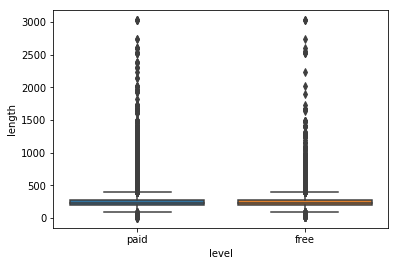

In [55]:
sns.boxplot(x="level", y="length", data=non_null_listening_time);

* downgrading versus non-downgrading users?
    

* cancelling versus non-cancelling users?

#### - How is the distribution of listening time for churning users in the 15 days prior to their churning compared to their overall distribution?

#### - How is the distribution of listening time for churning users in the 7 days prior to their churning compared to their overall distribution?

#### - Do churning users access Downgrading/Cancel pages more often than non-churning users overall / in the 15 / 7 days prior to their churning?

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### Build X dataframe

#### Select id, basic features and reference timestamp

In [56]:
X_base_df = df.groupBy(['userId','date']) \
                .agg(sf.first('month').alias('month'),
                     sf.first('region').alias('region'),
                     sf.first('gender').alias('gender'))

In [57]:
X_base_df.take(5)

[Row(userId='100', date='2018-10-25', month=10, region=' TX', gender='M'),
 Row(userId='100009', date='2018-10-01', month=10, region=' CA', gender='M'),
 Row(userId='100009', date='2018-10-05', month=10, region=' CA', gender='M'),
 Row(userId='124', date='2018-10-30', month=10, region=' NJ', gender='F'),
 Row(userId='131', date='2018-10-20', month=10, region=' TN-VA', gender='M')]

In [58]:
X_base_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- date: string (nullable = true)
 |-- month: integer (nullable = true)
 |-- region: string (nullable = true)
 |-- gender: string (nullable = true)



#### Add computed feature: Median Listening Time in the previous 1, 3, 7, and 14 days

In [59]:
recent_list_time = df.groupBy(['userId','date']) \
                    .agg(sf.mean('length').alias('mean_list_time')) \
                    .orderBy(['userId','date']) \
                    .fillna(0, subset=['mean_list_time']) \
                    .withColumn('timestamp',
                                sf.unix_timestamp(sf.col('date'), "yyyy-MM-dd")
)
recent_list_time.filter(recent_list_time.userId == '30').toPandas()

,userId,date,mean_list_time,timestamp
0,30,2018-10-01,269.813969,1538352000
1,30,2018-10-06,164.701590,1538784000
2,30,2018-10-07,232.347435,1538870400
3,30,2018-10-08,259.483355,1538956800
4,30,2018-10-10,396.146486,1539129600
5,30,2018-10-11,251.658676,1539216000
6,30,2018-10-15,259.953366,1539561600
7,30,2018-10-16,0.000000,1539648000
8,30,2018-10-20,0.000000,1539993600
9,30,2018-10-23,259.968068,1540252800


In [60]:
recent_list_time.printSchema()

root
 |-- userId: string (nullable = true)
 |-- date: string (nullable = true)
 |-- mean_list_time: double (nullable = false)
 |-- timestamp: long (nullable = true)



In [61]:
millis_in_a_day = 24*60*60
millis_in_a_day

86400

In [62]:
w_1day_before = Window.partitionBy(['userId']).orderBy('timestamp').rangeBetween(-((millis_in_a_day)-1),0)
w_3days_before = Window.partitionBy(['userId']).orderBy('timestamp').rangeBetween(-((3*millis_in_a_day)-1),0)
w_7days_before = Window.partitionBy(['userId']).orderBy('timestamp').rangeBetween(-((7*millis_in_a_day)-1),0)
w_14days_before = Window.partitionBy(['userId']).orderBy('timestamp').rangeBetween(-((14*millis_in_a_day)-1),0)

In [63]:
recent_list_time = recent_list_time.withColumn('mean_list_time_in_24_hours',sf.mean('mean_list_time').over(w_1day_before)) \
        .withColumn('mean_list_time_in_3_days',sf.mean('mean_list_time').over(w_3days_before)) \
        .withColumn('mean_list_time_in_7_days',sf.mean('mean_list_time').over(w_7days_before)) \
        .withColumn('mean_list_time_in_14_days',sf.mean('mean_list_time').over(w_14days_before))

In [64]:
recent_list_time.filter(df.userId == '30').toPandas()

,userId,date,mean_list_time,timestamp,mean_list_time_in_24_hours,mean_list_time_in_3_days,mean_list_time_in_7_days,mean_list_time_in_14_days
0,30,2018-10-01,269.813969,1538352000,269.813969,269.813969,269.813969,269.813969
1,30,2018-10-06,164.701590,1538784000,164.701590,164.701590,217.257779,217.257779
2,30,2018-10-07,232.347435,1538870400,232.347435,198.524513,222.287665,222.287665
3,30,2018-10-08,259.483355,1538956800,259.483355,218.844127,218.844127,231.586587
4,30,2018-10-10,396.146486,1539129600,396.146486,327.814920,263.169716,264.498567
5,30,2018-10-11,251.658676,1539216000,251.658676,323.902581,260.867508,262.358585
6,30,2018-10-15,259.953366,1539561600,259.953366,259.953366,302.586176,260.715151
7,30,2018-10-16,0.000000,1539648000,0.000000,129.976683,226.939632,223.470130
8,30,2018-10-20,0.000000,1539993600,0.000000,0.000000,86.651122,199.941331
9,30,2018-10-23,259.968068,1540252800,259.968068,259.968068,129.984034,194.621099


In [65]:
recent_list_time.printSchema()

root
 |-- userId: string (nullable = true)
 |-- date: string (nullable = true)
 |-- mean_list_time: double (nullable = false)
 |-- timestamp: long (nullable = true)
 |-- mean_list_time_in_24_hours: double (nullable = true)
 |-- mean_list_time_in_3_days: double (nullable = true)
 |-- mean_list_time_in_7_days: double (nullable = true)
 |-- mean_list_time_in_14_days: double (nullable = true)



#### Add computed feature: Time since last downgrade

#### Add computed feature: Accessed Cancel/Downgrade pages within last month/two weeks/3 days/24 hours/3 hours

#### Number of errors occurred (status code / error page) within last month/two weeks/3 days/24 hours/ 3 hours

#### Assemble final X dataframe

In [66]:
X_df = X_base_df.join(recent_list_time, on=['userId','date'], how='inner') \
                .drop('mean_list_time','timestamp')

In [67]:
X_df.filter(X_df.userId == '30').toPandas()

,userId,date,month,region,gender,mean_list_time_in_24_hours,mean_list_time_in_3_days,mean_list_time_in_7_days,mean_list_time_in_14_days
0,30,2018-10-08,10,CA,M,259.483355,218.844127,218.844127,231.586587
1,30,2018-10-27,10,CA,M,277.087983,259.735819,259.813235,173.232179
2,30,2018-11-10,11,CA,M,259.143798,251.147386,198.098379,224.057878
3,30,2018-11-23,11,CA,M,342.752200,342.752200,307.055873,273.329283
4,30,2018-11-05,11,CA,M,235.614778,249.443604,252.371022,254.851760
5,30,2018-10-16,10,CA,M,0.000000,129.976683,226.939632,223.470130
6,30,2018-11-30,11,CA,M,247.487670,251.828242,251.828242,279.442057
7,30,2018-10-23,10,CA,M,259.968068,259.968068,129.984034,194.621099
8,30,2018-11-02,11,CA,M,260.516795,255.298440,260.745826,220.762147
9,30,2018-11-04,11,CA,M,252.582343,257.744277,255.722271,257.256383


#### Add Y label - Whether or not the user will churn in the next day

In [70]:
#try sf.isnull
greater_than_0 = sf.udf(lambda x: 0 if (x == None) else 0 if (x > 0) else 1, st.IntegerType())

In [71]:
will_churn_in_future = df.groupBy(['userId','date']) \
                    .agg(greater_than_0(sf.sum('churned3')).alias('churned_today')) \
                    .orderBy(['userId','date']) \
                    .fillna(0, subset=['churned_today']) \
                    .withColumn('timestamp',
                                sf.unix_timestamp(sf.col('date'), "yyyy-MM-dd")
)
will_churn_in_future.filter(will_churn_in_future.userId == '30').toPandas()

,userId,date,churned_today,timestamp
0,30,2018-10-01,1,1538352000
1,30,2018-10-06,1,1538784000
2,30,2018-10-07,1,1538870400
3,30,2018-10-08,0,1538956800
4,30,2018-10-10,1,1539129600
5,30,2018-10-11,1,1539216000
6,30,2018-10-15,1,1539561600
7,30,2018-10-16,1,1539648000
8,30,2018-10-20,1,1539993600
9,30,2018-10-23,1,1540252800


In [72]:
w_1day_after = Window.partitionBy(['userId']).orderBy('timestamp').rangeBetween(millis_in_a_day,millis_in_a_day)
w_3days_after = Window.partitionBy(['userId']).orderBy('timestamp').rangeBetween(millis_in_a_day,3*millis_in_a_day)
w_7days_after = Window.partitionBy(['userId']).orderBy('timestamp').rangeBetween(millis_in_a_day,7*millis_in_a_day)
w_14days_after = Window.partitionBy(['userId']).orderBy('timestamp').rangeBetween(millis_in_a_day,14*millis_in_a_day)

In [79]:
will_churn_in_future = will_churn_in_future.withColumn('will_churn_in_1day',greater_than_0(sf.sum('churned_today').over(w_1day_after))) \
        .withColumn('will_churn_in_3days',greater_than_0(sf.sum('churned_today').over(w_3days_after))) \
        .withColumn('will_churn_in_7days',greater_than_0(sf.sum('churned_today').over(w_7days_after))) \
        .withColumn('will_churn_in_14days',greater_than_0(sf.sum('churned_today').over(w_14days_after))) \
        .fillna(0, subset=['will_churn_in_1day', 'will_churn_in_3days', 'will_churn_in_7days', 'will_churn_in_14days'])

In [80]:
will_churn_in_future.filter(df.userId == '30').toPandas()

,userId,date,churned_today,timestamp,will_churn_in_1day,will_churn_in_3days,will_churn_in_7days,will_churn_in_14days
0,30,2018-10-01,1,1538352000,0,0,0,0
1,30,2018-10-06,1,1538784000,0,0,0,0
2,30,2018-10-07,1,1538870400,1,0,0,0
3,30,2018-10-08,0,1538956800,0,0,0,0
4,30,2018-10-10,1,1539129600,0,0,0,0
5,30,2018-10-11,1,1539216000,0,0,0,0
6,30,2018-10-15,1,1539561600,0,0,0,0
7,30,2018-10-16,1,1539648000,0,0,0,0
8,30,2018-10-20,1,1539993600,0,0,0,0
9,30,2018-10-23,1,1540252800,0,0,0,0


In [81]:
model_df = X_df.join(will_churn_in_future.drop('timestamp'), on=['userId','date'], how='inner')

In [82]:
model_df.filter(df.userId == '30').toPandas()

,userId,date,month,region,gender,mean_list_time_in_24_hours,mean_list_time_in_3_days,mean_list_time_in_7_days,mean_list_time_in_14_days,churned_today,will_churn_in_1day,will_churn_in_3days,will_churn_in_7days,will_churn_in_14days
0,30,2018-10-08,10,CA,M,259.483355,218.844127,218.844127,231.586587,0,0,0,0,0
1,30,2018-10-27,10,CA,M,277.087983,259.735819,259.813235,173.232179,1,0,0,0,0
2,30,2018-11-10,11,CA,M,259.143798,251.147386,198.098379,224.057878,1,0,0,0,0
3,30,2018-11-23,11,CA,M,342.752200,342.752200,307.055873,273.329283,1,0,0,0,0
4,30,2018-11-05,11,CA,M,235.614778,249.443604,252.371022,254.851760,1,0,0,0,0
5,30,2018-10-16,10,CA,M,0.000000,129.976683,226.939632,223.470130,1,0,0,0,0
6,30,2018-11-30,11,CA,M,247.487670,251.828242,251.828242,279.442057,1,0,0,0,0
7,30,2018-10-23,10,CA,M,259.968068,259.968068,129.984034,194.621099,1,0,0,0,0
8,30,2018-11-02,11,CA,M,260.516795,255.298440,260.745826,220.762147,1,0,0,0,0
9,30,2018-11-04,11,CA,M,252.582343,257.744277,255.722271,257.256383,1,0,0,0,0


In [83]:
model_df.select("will_churn_in_14days").distinct().show()

+--------------------+
|will_churn_in_14days|
+--------------------+
|                   1|
|                   0|
+--------------------+



In [99]:
model_df.write.option("header", "true").csv("data/model_01_data.csv")

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [3]:
model_df = spark.read.csv("data/model_01_data.csv", header=True, inferSchema =True)

In [4]:
model_df.take(5)

[Row(userId=103, date=datetime.datetime(2018, 10, 19, 0, 0), month=10, region='NY-NJ-PA', gender='F', mean_list_time_in_24_hours=249.00718942857137, mean_list_time_in_3_days=249.00718942857137, mean_list_time_in_7_days=253.93027377994224, mean_list_time_in_14_days=249.75717271295247, churned_today=1, will_churn_in_1day=0, will_churn_in_3days=0, will_churn_in_7days=0, will_churn_in_14days=0),
 Row(userId=103, date=datetime.datetime(2018, 11, 3, 0, 0), month=11, region='NY-NJ-PA', gender='F', mean_list_time_in_24_hours=281.98975020833336, mean_list_time_in_3_days=281.98975020833336, mean_list_time_in_7_days=261.50605283651754, mean_list_time_in_14_days=196.12953962738814, churned_today=1, will_churn_in_1day=1, will_churn_in_3days=1, will_churn_in_7days=1, will_churn_in_14days=1),
 Row(userId=106, date=datetime.datetime(2018, 10, 3, 0, 0), month=10, region='CA', gender='F', mean_list_time_in_24_hours=246.11093580645158, mean_list_time_in_3_days=246.11093580645158, mean_list_time_in_7_days

In [5]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler, MinMaxScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [6]:
model_1_df = model_df.drop('userId','date','region','gender','churned_today','will_churn_in_1day',
                           'will_churn_in_3days','will_churn_in_14days') \
                .withColumnRenamed('will_churn_in_7days','label')

In [7]:
columns_to_scale = ['month','mean_list_time_in_24_hours','mean_list_time_in_3_days',
                    'mean_list_time_in_7_days','mean_list_time_in_14_days']

base_assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in columns_to_scale]
scalers = [MinMaxScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in columns_to_scale]
final_assembler = VectorAssembler(inputCols=[col + "_scaled" for col in columns_to_scale], outputCol="features")

#model_1_df = assembler.transform(model_1_df)
#scaler_model = scaler.fit(model_1_df)
#model_1_df = model_1_df.select(['raw_features','label'])

In [8]:
scalers[0].getInputCol(), scalers[0].getOutputCol()

('month_vec', 'month_scaled')

In [9]:
model_1_df.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   57|
|    0| 3128|
+-----+-----+



In [10]:
train, test, validation = model_1_df.randomSplit([0.6, 0.25, 0.15], seed=199)

In [11]:
#print(train.count(), test.count(), validation.count())

In [12]:
lr = LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)

In [13]:
pipeline = Pipeline(stages=base_assemblers + scalers + [final_assembler, lr])

In [14]:
pipeline.getStages()

[VectorAssembler_8cb9b1272c3e,
 VectorAssembler_9a3e6be64434,
 VectorAssembler_84765037a2a3,
 VectorAssembler_afabe5f2dbc8,
 VectorAssembler_69abefa2b397,
 MinMaxScaler_263897548c68,
 MinMaxScaler_1f1746480c3d,
 MinMaxScaler_a25633cfafdb,
 MinMaxScaler_dab6af85690a,
 MinMaxScaler_0132af657d16,
 VectorAssembler_e6c60ae3a4a8,
 LogisticRegression_d7e955bb7032]

In [16]:
final_assembler.getInputCols(), final_assembler.getOutputCol()

(['month_scaled',
  'mean_list_time_in_24_hours_scaled',
  'mean_list_time_in_3_days_scaled',
  'mean_list_time_in_7_days_scaled',
  'mean_list_time_in_14_days_scaled'],
 'features')

In [17]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.1, 0.5, 1]) \
    .build()


crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

In [18]:
%%time
cvModel = crossval.fit(train)

CPU times: user 2.11 s, sys: 539 ms, total: 2.65 s
Wall time: 1min 10s


In [19]:
cvModel.avgMetrics

[0.554870582965863, 0.5571681729538981, 0.5572367088398136]

In [20]:
test_preds = cvModel.transform(test)

In [21]:
test_preds.toPandas()

,month,mean_list_time_in_24_hours,mean_list_time_in_3_days,mean_list_time_in_7_days,mean_list_time_in_14_days,label,month_vec,mean_list_time_in_24_hours_vec,mean_list_time_in_3_days_vec,mean_list_time_in_7_days_vec,mean_list_time_in_14_days_vec,month_scaled,mean_list_time_in_24_hours_scaled,mean_list_time_in_3_days_scaled,mean_list_time_in_7_days_scaled,mean_list_time_in_14_days_scaled,features,rawPrediction,probability,prediction
0,10,0.000000,128.298807,179.447571,194.121076,0,[10.0],[0.0],[128.298806579],[179.447570706],[194.121075755],[0.0],[0.0],[0.202102705058],[0.282674799733],[0.393917082919],"[0.0, 0.0, 0.202102705058, 0.282674799733, 0.3...","[3.90605253141, -3.90605253141]","[0.980277054407, 0.0197229455933]",0.0
1,10,163.317100,242.446350,246.031077,246.031077,0,[10.0],[163.3171],[242.44635],[246.031077261],[246.031077261],[0.0],[0.163574620432],[0.381913631724],[0.38756047362],[0.499254621812],"[0.0, 0.163574620432, 0.381913631724, 0.387560...","[3.88673201157, -3.88673201157]","[0.979900025624, 0.0200999743757]",0.0
2,10,164.701590,164.701590,217.257779,217.257779,0,[10.0],[164.70159],[164.70159],[217.257779306],[217.257779306],[0.0],[0.164961293513],[0.259446192477],[0.342235333775],[0.44086686792],"[0.0, 0.164961293513, 0.259446192477, 0.342235...","[3.89403237205, -3.89403237205]","[0.980043310645, 0.0199566893554]",0.0
3,10,186.233015,230.340870,235.353093,235.353093,0,[10.0],[186.233015],[230.340869659],[235.353092609],[235.353092609],[0.0],[0.186526669532],[0.362844472873],[0.370739977466],[0.477586492532],"[0.0, 0.186526669532, 0.362844472873, 0.370739...","[3.88755027739, -3.88755027739]","[0.979916135832, 0.0200838641676]",0.0
4,10,207.575989,256.751500,256.751500,244.142218,0,[10.0],[207.575988571],[256.751499643],[256.751499643],[244.142218407],[0.0],[0.207903296969],[0.404447819813],[0.404447819813],[0.495421685245],"[0.0, 0.207903296969, 0.404447819813, 0.404447...","[3.88350051184, -3.88350051184]","[0.979836279315, 0.0201637206847]",0.0
5,10,215.055220,215.055220,107.527610,107.527610,0,[10.0],[215.05522],[215.05522],[107.52761],[107.52761],[0.0],[0.215394321743],[0.338765752057],[0.169382876029],[0.218198679869],"[0.0, 0.215394321743, 0.338765752057, 0.169382...","[3.8998103712, -3.8998103712]","[0.980156006282, 0.0198439937182]",0.0
6,10,221.058762,242.159258,244.424712,246.361774,0,[10.0],[221.058761923],[242.159257795],[244.424711796],[246.36177378],[0.0],[0.221407330125],[0.381461389705],[0.385030046296],[0.499925682427],"[0.0, 0.221407330125, 0.381461389705, 0.385030...","[3.88447819248, -3.88447819248]","[0.979855586435, 0.0201444135655]",0.0
7,10,222.697156,238.289235,249.587851,248.981421,0,[10.0],[222.697156429],[238.289234654],[249.587850996],[248.981421367],[0.0],[0.223048308071],[0.375365135451],[0.393163281724],[0.505241560322],"[0.0, 0.223048308071, 0.375365135451, 0.393163...","[3.88422331734, -3.88422331734]","[0.979850554937, 0.0201494450634]",0.0
8,10,223.477100,223.477100,223.477100,223.477100,0,[10.0],[223.4771],[223.4771],[223.4771],[223.4771],[0.0],[0.223829481468],[0.352032319183],[0.352032319183],[0.453487324798],"[0.0, 0.223829481468, 0.352032319183, 0.352032...","[3.88759555705, -3.88759555705]","[0.97991702694, 0.0200829730604]",0.0
9,10,231.490885,231.490885,231.490885,249.184399,0,[10.0],[231.490884815],[231.490884815],[231.490884815],[249.184399282],[0.0],[0.231855902518],[0.364656034337],[0.364656034337],[0.505653450005],"[0.0, 0.231855902518, 0.364656034337, 0.364656...","[3.88536691412, -3.88536691412]","[0.979873121091, 0.020126878909]",0.0


In [22]:
test_preds.groupby('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   14|
|    0|       0.0|  807|
+-----+----------+-----+



In [23]:
test_preds.select('features', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+--------------------+-----+--------------------+----------+--------------------+
|            features|label|       rawPrediction|prediction|         probability|
+--------------------+-----+--------------------+----------+--------------------+
|[0.0,0.0,0.202102...|    0|[3.90605253140964...|       0.0|[0.98027705440666...|
|[0.0,0.1635746204...|    0|[3.88673201156929...|       0.0|[0.97990002562432...|
|[0.0,0.1649612935...|    0|[3.89403237205320...|       0.0|[0.98004331064456...|
|[0.0,0.1865266695...|    0|[3.88755027738545...|       0.0|[0.97991613583237...|
|[0.0,0.2079032969...|    0|[3.88350051183956...|       0.0|[0.97983627931533...|
|[0.0,0.2153943217...|    0|[3.89981037119919...|       0.0|[0.98015600628180...|
|[0.0,0.2214073301...|    0|[3.88447819247912...|       0.0|[0.97985558643452...|
|[0.0,0.2230483080...|    0|[3.88422331733559...|       0.0|[0.97985055493655...|
|[0.0,0.2238294814...|    0|[3.88759555705148...|       0.0|[0.97991702693959...|
|[0.0,0.23185590

In [24]:
predictionAndLabels = test_preds.select("label", "rawPrediction","prediction")

In [25]:
predictionAndLabels.take(5)

[Row(label=0, rawPrediction=DenseVector([3.9061, -3.9061]), prediction=0.0),
 Row(label=0, rawPrediction=DenseVector([3.8867, -3.8867]), prediction=0.0),
 Row(label=0, rawPrediction=DenseVector([3.894, -3.894]), prediction=0.0),
 Row(label=0, rawPrediction=DenseVector([3.8876, -3.8876]), prediction=0.0),
 Row(label=0, rawPrediction=DenseVector([3.8835, -3.8835]), prediction=0.0)]

In [26]:
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

In [27]:
acc = evaluatorMulti.evaluate(predictionAndLabels, {evaluatorMulti.metricName: "accuracy"})
weightedPrecision = evaluatorMulti.evaluate(predictionAndLabels, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(predictionAndLabels, {evaluatorMulti.metricName: "weightedRecall"})
f1 = evaluatorMulti.evaluate(predictionAndLabels, {evaluatorMulti.metricName: "f1"})

In [28]:
auc = crossval.getEvaluator().evaluate(predictionAndLabels)

In [29]:
print('acc: ', acc)
print('weightedPrecision: ', weightedPrecision)
print('weightedRecall: ', weightedRecall)
print('f1: ', f1)
print('auc: ', auc)

acc:  0.9829476248477467
weightedPrecision:  0.9661860331938265
weightedRecall:  0.9829476248477467
f1:  0.9744947582950019
auc:  0.6244468047442024


## Dealing with Class Imbalance Problem

### Undersampling

#### Prepare Dataset 

In [30]:
model_1_df.toPandas().head()

,month,mean_list_time_in_24_hours,mean_list_time_in_3_days,mean_list_time_in_7_days,mean_list_time_in_14_days,label
0,10,249.007189,249.007189,253.930274,249.757173,0
1,11,281.989750,281.989750,261.506053,196.129540,1
2,10,246.110936,246.110936,246.110936,246.110936,0
3,11,245.563474,259.890329,252.793504,251.538462,0
4,11,240.829866,240.829866,247.302083,243.349693,0


In [31]:
churning_user_days = model_1_df.filter(model_1_df.label == 1)
print(churning_user_days.count())

57


In [32]:
churning_user_days.take(5)

[Row(month=11, mean_list_time_in_24_hours=281.98975020833336, mean_list_time_in_3_days=281.98975020833336, mean_list_time_in_7_days=261.50605283651754, mean_list_time_in_14_days=196.12953962738814, label=1),
 Row(month=10, mean_list_time_in_24_hours=241.6199284186046, mean_list_time_in_3_days=245.38535045582566, mean_list_time_in_7_days=245.2696237337629, mean_list_time_in_14_days=240.1653667688765, label=1),
 Row(month=10, mean_list_time_in_24_hours=250.87406395061734, mean_list_time_in_3_days=250.87406395061734, mean_list_time_in_7_days=250.87406395061734, mean_list_time_in_14_days=250.87406395061734, label=1),
 Row(month=11, mean_list_time_in_24_hours=229.68474363636366, mean_list_time_in_3_days=229.68474363636366, mean_list_time_in_7_days=229.68474363636366, mean_list_time_in_14_days=229.68474363636366, label=1),
 Row(month=11, mean_list_time_in_24_hours=233.57913874999997, mean_list_time_in_3_days=224.77488187499998, mean_list_time_in_7_days=246.86354802853594, mean_list_time_in_1

In [33]:
nonchurning_user_days = model_1_df.filter(model_1_df.label == 0)
print(nonchurning_user_days.count())

3128


In [34]:
nonchurning_user_days.take(5)

[Row(month=10, mean_list_time_in_24_hours=249.00718942857137, mean_list_time_in_3_days=249.00718942857137, mean_list_time_in_7_days=253.93027377994224, mean_list_time_in_14_days=249.75717271295247, label=0),
 Row(month=10, mean_list_time_in_24_hours=246.11093580645158, mean_list_time_in_3_days=246.11093580645158, mean_list_time_in_7_days=246.11093580645158, mean_list_time_in_14_days=246.11093580645158, label=0),
 Row(month=11, mean_list_time_in_24_hours=245.56347435294123, mean_list_time_in_3_days=259.8903291461676, mean_list_time_in_7_days=252.79350423952155, mean_list_time_in_14_days=251.53846235762327, label=0),
 Row(month=11, mean_list_time_in_24_hours=240.82986571428572, mean_list_time_in_3_days=240.82986571428572, mean_list_time_in_7_days=247.3020830423281, mean_list_time_in_14_days=243.34969250440918, label=0),
 Row(month=10, mean_list_time_in_24_hours=263.25708310344817, mean_list_time_in_3_days=263.25708310344817, mean_list_time_in_7_days=271.92397532122106, mean_list_time_in_

In [35]:
undersampling_ratio = churning_user_days.count()/nonchurning_user_days.count()
undersampled_nonchurning_user_days = nonchurning_user_days.sample(withReplacement=False, fraction=undersampling_ratio, seed=199)
undersampled_nonchurning_user_days.count()

62

In [36]:
undersampled_model_1_df = churning_user_days.union(undersampled_nonchurning_user_days)
undersampled_model_1_df.count()

119

In [37]:
undersampled_model_1_df.sample(0.05).show()

+-----+--------------------------+------------------------+------------------------+-------------------------+-----+
|month|mean_list_time_in_24_hours|mean_list_time_in_3_days|mean_list_time_in_7_days|mean_list_time_in_14_days|label|
+-----+--------------------------+------------------------+------------------------+-------------------------+-----+
|   10|         241.6199284186046|      245.38535045582566|       245.2696237337629|        240.1653667688765|    1|
|   10|        250.87406395061734|      250.87406395061734|      250.87406395061734|       250.87406395061734|    1|
|   10|        241.19102111111113|      241.19102111111113|      241.19102111111113|       241.19102111111113|    1|
|   10|         236.7680189655172|      243.30032213393554|      243.86643768370513|       243.86643768370513|    0|
|   10|         244.7246441836735|      250.25539013675765|      248.60872803803565|       245.52677895913368|    0|
|   11|                 265.26975|               265.26975|     

#### Train Model 

In [38]:
undersampled_model_1_df.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   57|
|    0|   62|
+-----+-----+



In [39]:
undersampled_model_1_df.select("label").distinct().toPandas()['label'].values

array([1, 0], dtype=int32)

In [40]:
sampling_var_values = undersampled_model_1_df.select("label").distinct().toPandas()['label'].values.tolist()

In [41]:
{val : 0.2/(1-0.6) for val in sampling_var_values}

{1: 0.5, 0: 0.5}

In [63]:
def generate_stratified_train_test_val_dfs(base_df, sampling_var, train_frac, test_frac, seed):
    # Taking (train_frac)% of both 0's and 1's into training set
    sampling_var_values = undersampled_model_1_df.select(sampling_var) \
                            .distinct().toPandas()[sampling_var].values.tolist()
    train_fracs = {val : train_frac for val in sampling_var_values}
    print('train_fracs', train_fracs)
    s_train = base_df.sampleBy(sampling_var, fractions=train_fracs, seed=seed)

    # Subtracting 'train' from 'base_df' to get test and validation sets
    # Taking (test_frac/(1-train_frac))% of both 0's and 1's into test set
    corrected_test_frac = test_frac/(1-train_frac)
    test_fracs = {val : corrected_test_frac for val in sampling_var_values}
    print('test_fracs', test_fracs)
    s_test = undersampled_model_1_df.subtract(s_train) \
            .sampleBy(sampling_var, fractions=test_fracs, seed=seed)

    # Subtracting 'train' and 'test' from 'base_df' to get validation set
    s_validation = undersampled_model_1_df.subtract(s_train).subtract(s_test)
    
    return(s_train, s_test, s_validation)

In [65]:
u_train, u_test, u_validation = generate_stratified_train_test_val_dfs(
    base_df = undersampled_model_1_df, sampling_var = 'label', 
    train_frac = 0.6, test_frac = 0.2, seed=199)

train_fracs {1: 0.6, 0: 0.6}
test_fracs {1: 0.5, 0: 0.5}


In [66]:
u_train.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   36|
|    0|   30|
+-----+-----+



In [67]:
u_test.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   11|
|    0|   20|
+-----+-----+



In [68]:
u_validation.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   10|
|    0|   12|
+-----+-----+



#### Evaluate Model 

In [69]:
%%time
cvModel = crossval.fit(u_train)

CPU times: user 2.24 s, sys: 478 ms, total: 2.72 s
Wall time: 51.9 s


In [70]:
cvModel.avgMetrics

[0.5519480519480519, 0.5949675324675324, 0.615530303030303]

In [71]:
u_test_preds = cvModel.transform(u_test)

In [72]:
u_test_preds.toPandas()

,month,mean_list_time_in_24_hours,mean_list_time_in_3_days,mean_list_time_in_7_days,mean_list_time_in_14_days,label,month_vec,mean_list_time_in_24_hours_vec,mean_list_time_in_3_days_vec,mean_list_time_in_7_days_vec,mean_list_time_in_14_days_vec,month_scaled,mean_list_time_in_24_hours_scaled,mean_list_time_in_3_days_scaled,mean_list_time_in_7_days_scaled,mean_list_time_in_14_days_scaled,features,rawPrediction,probability,prediction
0,10,221.361179,221.361179,221.361179,221.361179,0,[10.0],[221.361178889],[221.361178889],[221.361178889],[221.361178889],[0.0],[-0.0211996724176],[-0.0467284310303],[0.429834207983],[0.503481748318],"[0.0, -0.0211996724176, -0.0467284310303, 0.42...","[-0.503055666972, 0.503055666972]","[0.376822844881, 0.623177155119]",1.0
1,10,193.723625,193.723625,193.723625,193.723625,1,[10.0],[193.723625],[193.723625],[193.723625],[193.723625],[0.0],[-0.393641118701],[-0.48295196743],[0.207294715713],[0.296558021767],"[0.0, -0.393641118701, -0.48295196743, 0.20729...","[-0.77049808662, 0.77049808662]","[0.316371369976, 0.683628630024]",1.0
2,10,246.110936,246.110936,246.110936,246.110936,0,[10.0],[246.110935806],[246.110935806],[246.110935806],[246.110935806],[0.0],[0.312326054881],[0.343914913566],[0.629120959639],[0.68878439678],"[0.0, 0.312326054881, 0.343914913566, 0.629120...","[-0.263557811903, 0.263557811903]","[0.434489321226, 0.565510678774]",1.0
3,10,254.879547,253.601945,253.601945,253.601945,0,[10.0],[254.879546771],[253.601944782],[253.601944782],[253.601944782],[0.0],[0.430491148746],[0.462150935453],[0.68943908116],[0.744869949759],"[0.0, 0.430491148746, 0.462150935453, 0.689439...","[-0.190600532368, 0.190600532368]","[0.452493599841, 0.547506400159]",1.0
4,10,256.027043,252.536339,246.470807,244.432413,1,[10.0],[256.027043158],[252.536338912],[246.470806672],[244.432412631],[0.0],[0.445954717473],[0.445331705981],[0.632018664698],[0.676217211129],"[0.0, 0.445954717473, 0.445331705981, 0.632018...","[-0.268635024095, 0.268635024095]","[0.433242225268, 0.566757774732]",1.0
5,11,230.089151,230.089151,230.089151,246.941746,0,[11.0],[230.089151176],[230.089151176],[230.089151176],[246.941745665],[1.0],[0.0964177779175],[0.091031478989],[0.500112443504],[0.69500471109],"[1.0, 0.0964177779175, 0.091031478989, 0.50011...","[-0.135619279963, 0.135619279963]","[0.466147051059, 0.533852948941]",1.0
6,11,235.423077,235.423077,242.300954,246.571916,0,[11.0],[235.423077193],[235.423077193],[242.300954271],[246.571915861],[1.0],[0.168297334551],[0.17522069773],[0.598442725241],[0.692235777142],"[1.0, 0.168297334551, 0.17522069773, 0.5984427...","[-0.0856053865097, 0.0856053865097]","[0.478611713394, 0.521388286606]",1.0
7,11,242.482919,254.392289,250.515708,248.954093,0,[11.0],[242.482919463],[254.392288683],[250.515708004],[248.954092707],[1.0],[0.263435199363],[0.474625505839],[0.664588489518],[0.710071252462],"[1.0, 0.263435199363, 0.474625505839, 0.664588...","[-0.0397402616025, 0.0397402616025]","[0.490066241921, 0.509933758079]",1.0
8,10,243.023354,243.023354,240.530392,240.530392,0,[10.0],[243.023353673],[243.023353673],[240.530392449],[240.530392449],[0.0],[0.270718047177],[0.295181367812],[0.584186039191],[0.647002593935],"[0.0, 0.270718047177, 0.295181367812, 0.584186...","[-0.317141848344, 0.317141848344]","[0.421372458797, 0.578627541203]",1.0
9,11,264.007506,259.833731,173.222487,199.817450,0,[11.0],[264.007506377],[259.833730689],[173.222487126],[199.817449986],[1.0],[0.553498795918],[0.560511727339],[0.0422181379592],[0.342182789436],"[1.0, 0.553498795918, 0.560511727339, 0.042218...","[-0.617981356809, 0.617981356809]","[0.35024069941, 0.64975930059]",1.0


In [73]:
u_test_preds.groupby('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    0|       0.0|    2|
|    1|       1.0|   11|
|    0|       1.0|   18|
+-----+----------+-----+



In [74]:
u_test_preds.select('features', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+--------------------+-----+--------------------+----------+--------------------+
|            features|label|       rawPrediction|prediction|         probability|
+--------------------+-----+--------------------+----------+--------------------+
|[0.0,-0.021199672...|    0|[-0.5030556669719...|       1.0|[0.37682284488109...|
|[0.0,-0.393641118...|    1|[-0.7704980866201...|       1.0|[0.31637136997570...|
|[0.0,0.3123260548...|    0|[-0.2635578119030...|       1.0|[0.43448932122610...|
|[0.0,0.4304911487...|    0|[-0.1906005323677...|       1.0|[0.45249359984112...|
|[0.0,0.4459547174...|    1|[-0.2686350240953...|       1.0|[0.43324222526840...|
|[1.0,0.0964177779...|    0|[-0.1356192799629...|       1.0|[0.46614705105894...|
|[1.0,0.1682973345...|    0|[-0.0856053865097...|       1.0|[0.47861171339419...|
|[1.0,0.2634351993...|    0|[-0.0397402616025...|       1.0|[0.49006624192069...|
|[0.0,0.2707180471...|    0|[-0.3171418483435...|       1.0|[0.42137245879654...|
|[1.0,0.55349879

In [75]:
u_predictionAndLabels = u_test_preds.select("label", "rawPrediction","prediction")

In [76]:
u_predictionAndLabels.take(5)

[Row(label=0, rawPrediction=DenseVector([-0.5031, 0.5031]), prediction=1.0),
 Row(label=1, rawPrediction=DenseVector([-0.7705, 0.7705]), prediction=1.0),
 Row(label=0, rawPrediction=DenseVector([-0.2636, 0.2636]), prediction=1.0),
 Row(label=0, rawPrediction=DenseVector([-0.1906, 0.1906]), prediction=1.0),
 Row(label=1, rawPrediction=DenseVector([-0.2686, 0.2686]), prediction=1.0)]

In [77]:
acc = evaluatorMulti.evaluate(u_predictionAndLabels, {evaluatorMulti.metricName: "accuracy"})
weightedPrecision = evaluatorMulti.evaluate(u_predictionAndLabels, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(u_predictionAndLabels, {evaluatorMulti.metricName: "weightedRecall"})
f1 = evaluatorMulti.evaluate(u_predictionAndLabels, {evaluatorMulti.metricName: "f1"})

In [78]:
auc = crossval.getEvaluator().evaluate(u_predictionAndLabels)

In [79]:
print('acc: ', acc)
print('weightedPrecision: ', weightedPrecision)
print('weightedRecall: ', weightedRecall)
print('f1: ', f1)
print('auc: ', auc)

acc:  0.41935483870967744
weightedPrecision:  0.7797552836484983
weightedRecall:  0.41935483870967744
f1:  0.3124633431085044
auc:  0.709090909090909


In [80]:
u_y_true = u_predictionAndLabels.select(['label']).toPandas().label.values
u_y_pred = u_predictionAndLabels.select(['prediction']).toPandas().prediction.values

In [81]:
u_y_true

array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 1], dtype=int32)

In [82]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(u_y_true, u_y_pred))

             precision    recall  f1-score   support

          0       1.00      0.10      0.18        20
          1       0.38      1.00      0.55        11

avg / total       0.78      0.42      0.31        31



In [83]:
print(confusion_matrix(u_y_true, u_y_pred))

[[ 2 18]
 [ 0 11]]


#### Check Model Generalization 

##### - Original Train 

In [84]:
train_preds = cvModel.transform(train)

In [85]:
train_preds.toPandas()

,month,mean_list_time_in_24_hours,mean_list_time_in_3_days,mean_list_time_in_7_days,mean_list_time_in_14_days,label,month_vec,mean_list_time_in_24_hours_vec,mean_list_time_in_3_days_vec,mean_list_time_in_7_days_vec,mean_list_time_in_14_days_vec,month_scaled,mean_list_time_in_24_hours_scaled,mean_list_time_in_3_days_scaled,mean_list_time_in_7_days_scaled,mean_list_time_in_14_days_scaled,features,rawPrediction,probability,prediction
0,10,0.000000,0.000000,0.000000,0.000000,0,[10.0],[0.0],[0.0],[0.0],[0.0],[0.0],[-3.0042450587],[-3.54063229332],[-1.35258128928],[-1.15386029554],"[0.0, -3.0042450587, -3.54063229332, -1.352581...","[-2.64511822201, 2.64511822201]","[0.0662905334958, 0.933709466504]",1.0
1,10,0.000000,0.000000,0.000000,0.000000,0,[10.0],[0.0],[0.0],[0.0],[0.0],[0.0],[-3.0042450587],[-3.54063229332],[-1.35258128928],[-1.15386029554],"[0.0, -3.0042450587, -3.54063229332, -1.352581...","[-2.64511822201, 2.64511822201]","[0.0662905334958, 0.933709466504]",1.0
2,10,0.000000,0.000000,0.000000,0.000000,0,[10.0],[0.0],[0.0],[0.0],[0.0],[0.0],[-3.0042450587],[-3.54063229332],[-1.35258128928],[-1.15386029554],"[0.0, -3.0042450587, -3.54063229332, -1.352581...","[-2.64511822201, 2.64511822201]","[0.0662905334958, 0.933709466504]",1.0
3,10,0.000000,0.000000,0.000000,0.000000,0,[10.0],[0.0],[0.0],[0.0],[0.0],[0.0],[-3.0042450587],[-3.54063229332],[-1.35258128928],[-1.15386029554],"[0.0, -3.0042450587, -3.54063229332, -1.352581...","[-2.64511822201, 2.64511822201]","[0.0662905334958, 0.933709466504]",1.0
4,10,0.000000,0.000000,0.000000,0.000000,0,[10.0],[0.0],[0.0],[0.0],[0.0],[0.0],[-3.0042450587],[-3.54063229332],[-1.35258128928],[-1.15386029554],"[0.0, -3.0042450587, -3.54063229332, -1.352581...","[-2.64511822201, 2.64511822201]","[0.0662905334958, 0.933709466504]",1.0
5,10,0.000000,0.000000,0.000000,0.000000,0,[10.0],[0.0],[0.0],[0.0],[0.0],[0.0],[-3.0042450587],[-3.54063229332],[-1.35258128928],[-1.15386029554],"[0.0, -3.0042450587, -3.54063229332, -1.352581...","[-2.64511822201, 2.64511822201]","[0.0662905334958, 0.933709466504]",1.0
6,10,0.000000,0.000000,0.000000,0.000000,0,[10.0],[0.0],[0.0],[0.0],[0.0],[0.0],[-3.0042450587],[-3.54063229332],[-1.35258128928],[-1.15386029554],"[0.0, -3.0042450587, -3.54063229332, -1.352581...","[-2.64511822201, 2.64511822201]","[0.0662905334958, 0.933709466504]",1.0
7,10,0.000000,0.000000,0.000000,0.000000,0,[10.0],[0.0],[0.0],[0.0],[0.0],[0.0],[-3.0042450587],[-3.54063229332],[-1.35258128928],[-1.15386029554],"[0.0, -3.0042450587, -3.54063229332, -1.352581...","[-2.64511822201, 2.64511822201]","[0.0662905334958, 0.933709466504]",1.0
8,10,0.000000,0.000000,127.627026,168.129540,0,[10.0],[0.0],[0.0],[127.627025769],[168.129539846],[0.0],[-3.0042450587],[-3.54063229332],[-0.324919665223],[0.104933846235],"[0.0, -3.0042450587, -3.54063229332, -0.324919...","[-1.21578042125, 1.21578042125]","[0.228679870393, 0.771320129607]",1.0
9,10,209.031384,239.806300,249.064696,249.064696,0,[10.0],[209.031383846],[239.806300105],[249.064696105],[249.064696105],[0.0],[-0.18735499559],[0.244404280588],[0.65290484152],[0.71089934555],"[0.0, -0.18735499559, 0.244404280588, 0.652904...","[-0.247810300024, 0.247810300024]","[0.438362532082, 0.561637467918]",1.0


In [86]:
train_preds.groupby('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|    2|
|    0|       0.0|  208|
|    1|       1.0|   36|
|    0|       1.0| 1647|
+-----+----------+-----+



In [88]:
train_preds.select('features', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+--------------------+-----+--------------------+----------+--------------------+
|            features|label|       rawPrediction|prediction|         probability|
+--------------------+-----+--------------------+----------+--------------------+
|[0.0,-3.004245058...|    0|[-2.6451182220099...|       1.0|[0.06629053349579...|
|[0.0,-3.004245058...|    0|[-2.6451182220099...|       1.0|[0.06629053349579...|
|[0.0,-3.004245058...|    0|[-2.6451182220099...|       1.0|[0.06629053349579...|
|[0.0,-3.004245058...|    0|[-2.6451182220099...|       1.0|[0.06629053349579...|
|[0.0,-3.004245058...|    0|[-2.6451182220099...|       1.0|[0.06629053349579...|
|[0.0,-3.004245058...|    0|[-2.6451182220099...|       1.0|[0.06629053349579...|
|[0.0,-3.004245058...|    0|[-2.6451182220099...|       1.0|[0.06629053349579...|
|[0.0,-3.004245058...|    0|[-2.6451182220099...|       1.0|[0.06629053349579...|
|[0.0,-3.004245058...|    0|[-1.2157804212494...|       1.0|[0.22867987039307...|
|[0.0,-0.1873549

In [89]:
train_predictionAndLabels = train_preds.select("label", "rawPrediction","prediction")

In [90]:
train_predictionAndLabels.take(5)

[Row(label=0, rawPrediction=DenseVector([-2.6451, 2.6451]), prediction=1.0),
 Row(label=0, rawPrediction=DenseVector([-2.6451, 2.6451]), prediction=1.0),
 Row(label=0, rawPrediction=DenseVector([-2.6451, 2.6451]), prediction=1.0),
 Row(label=0, rawPrediction=DenseVector([-2.6451, 2.6451]), prediction=1.0),
 Row(label=0, rawPrediction=DenseVector([-2.6451, 2.6451]), prediction=1.0)]

In [91]:
acc = evaluatorMulti.evaluate(train_predictionAndLabels, {evaluatorMulti.metricName: "accuracy"})
weightedPrecision = evaluatorMulti.evaluate(train_predictionAndLabels, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(train_predictionAndLabels, {evaluatorMulti.metricName: "weightedRecall"})
f1 = evaluatorMulti.evaluate(train_predictionAndLabels, {evaluatorMulti.metricName: "f1"})

In [92]:
auc = crossval.getEvaluator().evaluate(train_predictionAndLabels)

In [93]:
print('acc: ', acc)
print('weightedPrecision: ', weightedPrecision)
print('weightedRecall: ', weightedRecall)
print('f1: ', f1)
print('auc: ', auc)

acc:  0.1288959323824617
weightedPrecision:  0.9710228037812638
weightedRecall:  0.12889593238246172
f1:  0.19824864693174996
auc:  0.5330401475386586


In [94]:
train_y_true = train_predictionAndLabels.select(['label']).toPandas().label.values
train_y_pred = train_predictionAndLabels.select(['prediction']).toPandas().prediction.values

In [95]:
train_y_true

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [96]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(train_y_true, train_y_pred))

             precision    recall  f1-score   support

          0       0.99      0.11      0.20      1855
          1       0.02      0.95      0.04        38

avg / total       0.97      0.13      0.20      1893



In [97]:
print(confusion_matrix(train_y_true, train_y_pred))

[[ 208 1647]
 [   2   36]]


#####  - Original Test 

In [98]:
test_preds = cvModel.transform(test)

In [99]:
test_preds.toPandas()

,month,mean_list_time_in_24_hours,mean_list_time_in_3_days,mean_list_time_in_7_days,mean_list_time_in_14_days,label,month_vec,mean_list_time_in_24_hours_vec,mean_list_time_in_3_days_vec,mean_list_time_in_7_days_vec,mean_list_time_in_14_days_vec,month_scaled,mean_list_time_in_24_hours_scaled,mean_list_time_in_3_days_scaled,mean_list_time_in_7_days_scaled,mean_list_time_in_14_days_scaled,features,rawPrediction,probability,prediction
0,10,0.000000,128.298807,179.447571,194.121076,0,[10.0],[0.0],[128.298806579],[179.447570706],[194.121075755],[0.0],[-3.0042450587],[-1.51559927676],[0.0923429407865],[0.299533755139],"[0.0, -3.0042450587, -1.51559927676, 0.0923429...","[-0.886111496007, 0.886111496007]","[0.291912929479, 0.708087070521]",1.0
1,10,163.317100,242.446350,246.031077,246.031077,0,[10.0],[163.3171],[242.44635],[246.031077261],[246.031077261],[0.0],[-0.803396996265],[0.286074100795],[0.628477933115],[0.688186491917],"[0.0, -0.803396996265, 0.286074100795, 0.62847...","[-0.293945742784, 0.293945742784]","[0.427038159495, 0.572961840505]",1.0
2,10,164.701590,164.701590,217.257779,217.257779,0,[10.0],[164.70159],[164.70159],[217.257779306],[217.257779306],[0.0],[-0.784739720732],[-0.941027772261],[0.396793351201],[0.472759393629],"[0.0, -0.784739720732, -0.941027772261, 0.3967...","[-0.551567790996, 0.551567790996]","[0.365500746047, 0.634499253953]",1.0
3,10,186.233015,230.340870,235.353093,235.353093,0,[10.0],[186.233015],[230.340869659],[235.353092609],[235.353092609],[0.0],[-0.494583974685],[0.0950045341611],[0.54249806339],[0.608239895156],"[0.0, -0.494583974685, 0.0950045341611, 0.5424...","[-0.384671918819, 0.384671918819]","[0.405000583068, 0.594999416932]",1.0
4,10,207.575989,256.751500,256.751500,244.142218,0,[10.0],[207.575988571],[256.751499643],[256.751499643],[244.142218407],[0.0],[-0.206967784884],[0.51186264167],[0.714799514374],[0.674044512692],"[0.0, -0.206967784884, 0.51186264167, 0.714799...","[-0.245774855472, 0.245774855472]","[0.438863722911, 0.561136277089]",1.0
5,10,215.055220,215.055220,107.527610,107.527610,0,[10.0],[215.05522],[215.05522],[107.52761],[107.52761],[0.0],[-0.106178265611],[-0.146259948833],[-0.486761548849],[-0.34879578593],"[0.0, -0.106178265611, -0.146259948833, -0.486...","[-1.58658411984, 1.58658411984]","[0.169865030233, 0.830134969767]",1.0
6,10,221.058762,242.159258,244.424712,246.361774,0,[10.0],[221.058761923],[242.159257795],[244.424711796],[246.36177378],[0.0],[-0.0252750190485],[0.281542716524],[0.615543367471],[0.690662433039],"[0.0, -0.0252750190485, 0.281542716524, 0.6155...","[-0.27767552086, 0.27767552086]","[0.431023744974, 0.568976255026]",1.0
7,10,222.697156,238.289235,249.587851,248.981421,0,[10.0],[222.697156429],[238.289234654],[249.587850996],[248.981421367],[0.0],[-0.00319614688558],[0.220459337463],[0.657117320823],[0.710275863484],"[0.0, -0.00319614688558, 0.220459337463, 0.657...","[-0.240752087332, 0.240752087332]","[0.440101018964, 0.559898981036]",1.0
8,10,223.477100,223.477100,223.477100,223.477100,0,[10.0],[223.4771],[223.4771],[223.4771],[223.4771],[0.0],[0.00731430975361],[-0.0133313151516],[0.446871750873],[0.519323753843],"[0.0, 0.00731430975361, -0.0133313151516, 0.44...","[-0.482580372233, 0.482580372233]","[0.381642993316, 0.618357006684]",1.0
9,10,231.490885,231.490885,231.490885,249.184399,0,[10.0],[231.490884815],[231.490884815],[231.490884815],[249.184399282],[0.0],[0.11530742733],[0.113156056557],[0.511399299549],[0.71179556913],"[0.0, 0.11530742733, 0.113156056557, 0.5113992...","[-0.310804143112, 0.310804143112]","[0.422918468801, 0.577081531199]",1.0


In [100]:
test_preds.groupby('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|    1|
|    0|       0.0|  101|
|    1|       1.0|   13|
|    0|       1.0|  706|
+-----+----------+-----+



In [101]:
test_preds.select('features', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+--------------------+-----+--------------------+----------+--------------------+
|            features|label|       rawPrediction|prediction|         probability|
+--------------------+-----+--------------------+----------+--------------------+
|[0.0,-3.004245058...|    0|[-0.8861114960065...|       1.0|[0.29191292947929...|
|[0.0,-0.803396996...|    0|[-0.2939457427840...|       1.0|[0.42703815949530...|
|[0.0,-0.784739720...|    0|[-0.5515677909955...|       1.0|[0.36550074604680...|
|[0.0,-0.494583974...|    0|[-0.3846719188192...|       1.0|[0.40500058306802...|
|[0.0,-0.206967784...|    0|[-0.2457748554718...|       1.0|[0.43886372291127...|
|[0.0,-0.106178265...|    0|[-1.5865841198395...|       1.0|[0.16986503023309...|
|[0.0,-0.025275019...|    0|[-0.2776755208604...|       1.0|[0.43102374497407...|
|[0.0,-0.003196146...|    0|[-0.2407520873322...|       1.0|[0.44010101896447...|
|[0.0,0.0073143097...|    0|[-0.4825803722329...|       1.0|[0.38164299331593...|
|[0.0,0.11530742

In [102]:
test_predictionAndLabels = test_preds.select("label", "rawPrediction","prediction")

In [103]:
test_predictionAndLabels.take(5)

[Row(label=0, rawPrediction=DenseVector([-0.8861, 0.8861]), prediction=1.0),
 Row(label=0, rawPrediction=DenseVector([-0.2939, 0.2939]), prediction=1.0),
 Row(label=0, rawPrediction=DenseVector([-0.5516, 0.5516]), prediction=1.0),
 Row(label=0, rawPrediction=DenseVector([-0.3847, 0.3847]), prediction=1.0),
 Row(label=0, rawPrediction=DenseVector([-0.2458, 0.2458]), prediction=1.0)]

In [104]:
acc = evaluatorMulti.evaluate(test_predictionAndLabels, {evaluatorMulti.metricName: "accuracy"})
weightedPrecision = evaluatorMulti.evaluate(test_predictionAndLabels, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(test_predictionAndLabels, {evaluatorMulti.metricName: "weightedRecall"})
f1 = evaluatorMulti.evaluate(test_predictionAndLabels, {evaluatorMulti.metricName: "f1"})

In [105]:
auc = crossval.getEvaluator().evaluate(test_predictionAndLabels)

In [106]:
print('acc: ', acc)
print('weightedPrecision: ', weightedPrecision)
print('weightedRecall: ', weightedRecall)
print('f1: ', f1)
print('auc: ', auc)

acc:  0.13885505481120586
weightedPrecision:  0.9736192017544847
weightedRecall:  0.13885505481120586
f1:  0.21903766466764044
auc:  0.6616215259337934


In [107]:
test_y_true = test_predictionAndLabels.select(['label']).toPandas().label.values
test_y_pred = test_predictionAndLabels.select(['prediction']).toPandas().prediction.values

In [108]:
test_y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0,

In [109]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_y_true, test_y_pred))

             precision    recall  f1-score   support

          0       0.99      0.13      0.22       807
          1       0.02      0.93      0.04        14

avg / total       0.97      0.14      0.22       821



In [110]:
print(confusion_matrix(test_y_true, test_y_pred))

[[101 706]
 [  1  13]]


### Class Weights

#### Define class weights 

In [ ]:
def balanceDataset(dataset: DataFrame, label: String = "label"): DataFrame = {
  // Re-balancing (weighting) of records to be used in the logistic loss objective function
  val (datasetSize, positives) = dataset.select(count("*"), sum(dataset(label))).as[(Long, Double)].collect.head
  val balancingRatio = positives / datasetSize

  val weightedDataset = {
    dataset.withColumn("classWeightCol", when(dataset(label) === 0.0, balancingRatio).otherwise(1.0 - balancingRatio))
  }
  weightedDataset
}
    
df=df.withColumn('new_column', 
F.when(F.col('fruit1')==F.col('fruit2'), 1)
.otherwise(F.when((F.col('fruit1').isNull()) | (F.col('fruit2').isNull()), 3))
.otherwise(0))

In [125]:
balancing_ratio = train.select(sf.sum('label')).collect()[0][0]/train.count()
balancing_ratio

0.020073956682514528

In [126]:
w_train = train.withColumn('class_weight', sf.when(sf.col('label') == 0, balancing_ratio) \
                            .otherwise(1-balancing_ratio))

In [132]:
w_train.take(5)

[Row(month=10, mean_list_time_in_24_hours=0.0, mean_list_time_in_3_days=0.0, mean_list_time_in_7_days=0.0, mean_list_time_in_14_days=0.0, label=0, class_weight=0.020073956682514528),
 Row(month=10, mean_list_time_in_24_hours=0.0, mean_list_time_in_3_days=0.0, mean_list_time_in_7_days=0.0, mean_list_time_in_14_days=0.0, label=0, class_weight=0.020073956682514528),
 Row(month=10, mean_list_time_in_24_hours=0.0, mean_list_time_in_3_days=0.0, mean_list_time_in_7_days=0.0, mean_list_time_in_14_days=0.0, label=0, class_weight=0.020073956682514528),
 Row(month=10, mean_list_time_in_24_hours=0.0, mean_list_time_in_3_days=0.0, mean_list_time_in_7_days=0.0, mean_list_time_in_14_days=0.0, label=0, class_weight=0.020073956682514528),
 Row(month=10, mean_list_time_in_24_hours=0.0, mean_list_time_in_3_days=0.0, mean_list_time_in_7_days=0.0, mean_list_time_in_14_days=0.0, label=0, class_weight=0.020073956682514528)]

In [133]:
w_train.filter(sf.col('label') == 1).take(5)

[Row(month=10, mean_list_time_in_24_hours=241.6199284186046, mean_list_time_in_3_days=245.38535045582566, mean_list_time_in_7_days=245.2696237337629, mean_list_time_in_14_days=240.1653667688765, label=1, class_weight=0.9799260433174855),
 Row(month=10, mean_list_time_in_24_hours=241.67273465517238, mean_list_time_in_3_days=245.60398612375545, mean_list_time_in_7_days=250.39488371234853, mean_list_time_in_14_days=228.47008623102687, label=1, class_weight=0.9799260433174855),
 Row(month=10, mean_list_time_in_24_hours=250.87406395061734, mean_list_time_in_3_days=250.87406395061734, mean_list_time_in_7_days=250.87406395061734, mean_list_time_in_14_days=250.87406395061734, label=1, class_weight=0.9799260433174855),
 Row(month=10, mean_list_time_in_24_hours=263.7991610526316, mean_list_time_in_3_days=263.7991610526316, mean_list_time_in_7_days=263.7991610526316, mean_list_time_in_14_days=263.7991610526316, label=1, class_weight=0.9799260433174855),
 Row(month=11, mean_list_time_in_24_hours=2

#### Redefine model and pipeline using weight column 

In [136]:
w_lr = LogisticRegression(regParam=0.1, elasticNetParam=0).setWeightCol("class_weight")

In [137]:
w_pipeline = Pipeline(stages=base_assemblers + scalers + [final_assembler, w_lr])

In [139]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.1, 0.5, 1]) \
    .build()


w_crossval = CrossValidator(estimator=w_pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

#### Train weighted model

In [141]:
%%time
w_cvModel = w_crossval.fit(w_train)

CPU times: user 2.05 s, sys: 565 ms, total: 2.62 s
Wall time: 51.7 s


In [142]:
w_cvModel.avgMetrics

[0.5442512266392946, 0.5442512266392946, 0.5442512266392946]

In [143]:
w_test_preds = cvModel.transform(test)

In [144]:
w_test_preds.toPandas()

,month,mean_list_time_in_24_hours,mean_list_time_in_3_days,mean_list_time_in_7_days,mean_list_time_in_14_days,label,month_vec,mean_list_time_in_24_hours_vec,mean_list_time_in_3_days_vec,mean_list_time_in_7_days_vec,mean_list_time_in_14_days_vec,month_scaled,mean_list_time_in_24_hours_scaled,mean_list_time_in_3_days_scaled,mean_list_time_in_7_days_scaled,mean_list_time_in_14_days_scaled,features,rawPrediction,probability,prediction
0,10,0.000000,128.298807,179.447571,194.121076,0,[10.0],[0.0],[128.298806579],[179.447570706],[194.121075755],[0.0],[-3.0042450587],[-1.51559927676],[0.0923429407865],[0.299533755139],"[0.0, -3.0042450587, -1.51559927676, 0.0923429...","[-0.886111496007, 0.886111496007]","[0.291912929479, 0.708087070521]",1.0
1,10,163.317100,242.446350,246.031077,246.031077,0,[10.0],[163.3171],[242.44635],[246.031077261],[246.031077261],[0.0],[-0.803396996265],[0.286074100795],[0.628477933115],[0.688186491917],"[0.0, -0.803396996265, 0.286074100795, 0.62847...","[-0.293945742784, 0.293945742784]","[0.427038159495, 0.572961840505]",1.0
2,10,164.701590,164.701590,217.257779,217.257779,0,[10.0],[164.70159],[164.70159],[217.257779306],[217.257779306],[0.0],[-0.784739720732],[-0.941027772261],[0.396793351201],[0.472759393629],"[0.0, -0.784739720732, -0.941027772261, 0.3967...","[-0.551567790996, 0.551567790996]","[0.365500746047, 0.634499253953]",1.0
3,10,186.233015,230.340870,235.353093,235.353093,0,[10.0],[186.233015],[230.340869659],[235.353092609],[235.353092609],[0.0],[-0.494583974685],[0.0950045341611],[0.54249806339],[0.608239895156],"[0.0, -0.494583974685, 0.0950045341611, 0.5424...","[-0.384671918819, 0.384671918819]","[0.405000583068, 0.594999416932]",1.0
4,10,207.575989,256.751500,256.751500,244.142218,0,[10.0],[207.575988571],[256.751499643],[256.751499643],[244.142218407],[0.0],[-0.206967784884],[0.51186264167],[0.714799514374],[0.674044512692],"[0.0, -0.206967784884, 0.51186264167, 0.714799...","[-0.245774855472, 0.245774855472]","[0.438863722911, 0.561136277089]",1.0
5,10,215.055220,215.055220,107.527610,107.527610,0,[10.0],[215.05522],[215.05522],[107.52761],[107.52761],[0.0],[-0.106178265611],[-0.146259948833],[-0.486761548849],[-0.34879578593],"[0.0, -0.106178265611, -0.146259948833, -0.486...","[-1.58658411984, 1.58658411984]","[0.169865030233, 0.830134969767]",1.0
6,10,221.058762,242.159258,244.424712,246.361774,0,[10.0],[221.058761923],[242.159257795],[244.424711796],[246.36177378],[0.0],[-0.0252750190485],[0.281542716524],[0.615543367471],[0.690662433039],"[0.0, -0.0252750190485, 0.281542716524, 0.6155...","[-0.27767552086, 0.27767552086]","[0.431023744974, 0.568976255026]",1.0
7,10,222.697156,238.289235,249.587851,248.981421,0,[10.0],[222.697156429],[238.289234654],[249.587850996],[248.981421367],[0.0],[-0.00319614688558],[0.220459337463],[0.657117320823],[0.710275863484],"[0.0, -0.00319614688558, 0.220459337463, 0.657...","[-0.240752087332, 0.240752087332]","[0.440101018964, 0.559898981036]",1.0
8,10,223.477100,223.477100,223.477100,223.477100,0,[10.0],[223.4771],[223.4771],[223.4771],[223.4771],[0.0],[0.00731430975361],[-0.0133313151516],[0.446871750873],[0.519323753843],"[0.0, 0.00731430975361, -0.0133313151516, 0.44...","[-0.482580372233, 0.482580372233]","[0.381642993316, 0.618357006684]",1.0
9,10,231.490885,231.490885,231.490885,249.184399,0,[10.0],[231.490884815],[231.490884815],[231.490884815],[249.184399282],[0.0],[0.11530742733],[0.113156056557],[0.511399299549],[0.71179556913],"[0.0, 0.11530742733, 0.113156056557, 0.5113992...","[-0.310804143112, 0.310804143112]","[0.422918468801, 0.577081531199]",1.0


In [145]:
w_test_preds.groupby('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|    1|
|    0|       0.0|  101|
|    1|       1.0|   13|
|    0|       1.0|  706|
+-----+----------+-----+



In [146]:
w_test_preds.select('features', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+--------------------+-----+--------------------+----------+--------------------+
|            features|label|       rawPrediction|prediction|         probability|
+--------------------+-----+--------------------+----------+--------------------+
|[0.0,-3.004245058...|    0|[-0.8861114960065...|       1.0|[0.29191292947929...|
|[0.0,-0.803396996...|    0|[-0.2939457427840...|       1.0|[0.42703815949530...|
|[0.0,-0.784739720...|    0|[-0.5515677909955...|       1.0|[0.36550074604680...|
|[0.0,-0.494583974...|    0|[-0.3846719188192...|       1.0|[0.40500058306802...|
|[0.0,-0.206967784...|    0|[-0.2457748554718...|       1.0|[0.43886372291127...|
|[0.0,-0.106178265...|    0|[-1.5865841198395...|       1.0|[0.16986503023309...|
|[0.0,-0.025275019...|    0|[-0.2776755208604...|       1.0|[0.43102374497407...|
|[0.0,-0.003196146...|    0|[-0.2407520873322...|       1.0|[0.44010101896447...|
|[0.0,0.0073143097...|    0|[-0.4825803722329...|       1.0|[0.38164299331593...|
|[0.0,0.11530742

In [160]:
w_predictionAndLabels = w_test_preds.select("label", "rawPrediction","prediction")

In [161]:
w_predictionAndLabels.take(5)

[Row(label=0, rawPrediction=DenseVector([-0.8861, 0.8861]), prediction=1.0),
 Row(label=0, rawPrediction=DenseVector([-0.2939, 0.2939]), prediction=1.0),
 Row(label=0, rawPrediction=DenseVector([-0.5516, 0.5516]), prediction=1.0),
 Row(label=0, rawPrediction=DenseVector([-0.3847, 0.3847]), prediction=1.0),
 Row(label=0, rawPrediction=DenseVector([-0.2458, 0.2458]), prediction=1.0)]

In [162]:
acc = evaluatorMulti.evaluate(w_predictionAndLabels, {evaluatorMulti.metricName: "accuracy"})
weightedPrecision = evaluatorMulti.evaluate(w_predictionAndLabels, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(w_predictionAndLabels, {evaluatorMulti.metricName: "weightedRecall"})
f1 = evaluatorMulti.evaluate(w_predictionAndLabels, {evaluatorMulti.metricName: "f1"})

In [163]:
auc = crossval.getEvaluator().evaluate(w_predictionAndLabels)

In [164]:
print('acc: ', acc)
print('weightedPrecision: ', weightedPrecision)
print('weightedRecall: ', weightedRecall)
print('f1: ', f1)
print('auc: ', auc)

acc:  0.13885505481120586
weightedPrecision:  0.9736192017544847
weightedRecall:  0.13885505481120586
f1:  0.21903766466764044
auc:  0.6616215259337934


In [165]:
w_y_true = w_predictionAndLabels.select(['label']).toPandas().label.values
w_y_pred = w_predictionAndLabels.select(['prediction']).toPandas().prediction.values

In [166]:
w_y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0,

In [167]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(w_y_true, w_y_pred))

             precision    recall  f1-score   support

          0       0.99      0.13      0.22       807
          1       0.02      0.93      0.04        14

avg / total       0.97      0.14      0.22       821



In [168]:
print(confusion_matrix(w_y_true, w_y_pred))

[[101 706]
 [  1  13]]


In [82]:
# # Print the coefficients and intercept for multinomial logistic regression
# print("Coefficients: \n" + str(cvModel.bestModel.getParam('estimator').confusion_matrix))
# print("Intercept: " + str(lr_model.intercept))

In [83]:
#trainingSummary = lr_model.summary

In [84]:
# accuracy = trainingSummary.accuracy
# falsePositiveRate = trainingSummary.weightedFalsePositiveRate
# truePositiveRate = trainingSummary.weightedTruePositiveRate
# fMeasure = trainingSummary.weightedFMeasure()
# precision = trainingSummary.weightedPrecision
# recall = trainingSummary.weightedRecall
# print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
#       % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

In [85]:
# evaluator = BinaryClassificationEvaluator()
# print('Test Area Under ROC', evaluator.evaluate(test_preds))

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.